In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## One cycle

In [2]:
spm = pybamm.lithium_ion.SPM({"sei": "ec reaction limited"})
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 3V",
])
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
})
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

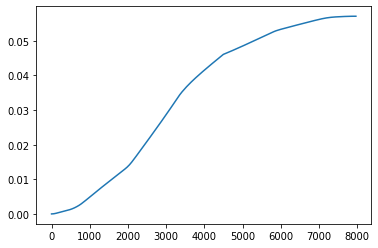

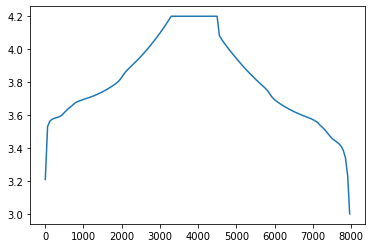

In [3]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)

In [4]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## 10 cycles

In [18]:
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 3V",
] * 5 + ["Hold at 3V until C/50"])
sim_10 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol_10 = sim_10.solve()

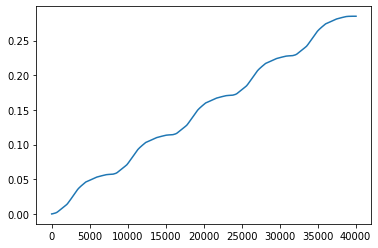

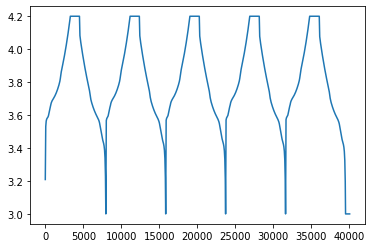

In [19]:
plt.plot(spm_sol_10["Time [s]"].data, spm_sol_10["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol_10["Time [s]"].data, spm_sol_10["Terminal voltage [V]"].data)

In [20]:
lli_10 = spm_sol_10["Loss of Lithium Inventory [%]"].data
lli_ten_cycles = lli_10[-1] - lli_10[0]

## Compare

Compare LLI

In [21]:
print(lli_one_cycle * 5)
print(lli_ten_cycles)

0.2854709011249623
0.2851432682116961


Compare x0, y0

In [22]:
x_0 = spm_sol_10["Negative electrode SOC"].data[-1]
y_0 = spm_sol_10["Positive electrode SOC"].data[-1]

Multiply LLI by 5 and use this to initialize next simulation

In [23]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
F = parameter_values.evaluate(param.F)
n_Li = (1 - lli_one_cycle * 5 / 100) * n_Li_init

esoh_sol = esoh_sim.solve(
    [0],
    inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
)
print(esoh_sol["x_0"].data[0])
print(x_0)
print(esoh_sol["y_0"].data[0])
print(y_0)

0.00025564037312530985
0.001122344669524267
0.8896418796815468
0.8887515449552111


In [24]:
n_Li_true = (x_0 * Cn + y_0 * Cp) * 3600 / F
n_Li_approx = (esoh_sol["x_0"].data[0] * Cn + esoh_sol["y_0"].data[0] * Cp) * 3600 / F
print(n_Li_true)
print(n_Li_approx)
print(n_Li_init)

print(abs(n_Li_true - n_Li_approx))
print(abs(n_Li_true - n_Li_init))
print(abs(n_Li_true - n_Li_approx) / abs(n_Li_true - n_Li_init))

0.19243840523133976
0.19243777293684117
0.19298869951642003
6.322944985925893e-07
0.0005502942850802717
0.0011490115666026883


In [19]:
x_0 = spm_sol["Negative electrode SOC"].data[-1]
y_0 = spm_sol["Positive electrode SOC"].data[-1]
n_Li = (1 - lli_one_cycle / 100) * n_Li_init

esoh_sol = esoh_sim.solve(
    [0],
    inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
)
print(esoh_sol["x_0"].data[0])
print(x_0)
print(esoh_sol["y_0"].data[0])
print(y_0)

0.00029943296277812337
0.03594297012661527
0.891634904551005
0.8548993077978535


In [20]:
print((x_0 * Cn + y_0 * Cp) * 3600 / F)
print((esoh_sol["x_0"].data[0] * Cn + esoh_sol["y_0"].data[0] * Cp) * 3600 / F)
# print(n_Li_init)
# print((esoh_sol.model.variables.keys()))
print(esoh_sol["n_Li_0"].data)
print(n_Li)

0.1928785151065313
0.19287851510653123
[0.19287852]
0.19287851510653123


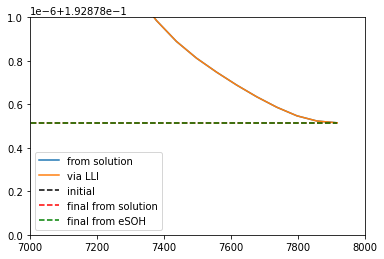

In [21]:
t = spm_sol["Time [s]"].data
n_Li_sol = spm_sol["Total lithium in particles [mol]"].data
lli = spm_sol["Loss of Lithium Inventory [%]"].data

fig, ax = plt.subplots()
ax.plot(t, n_Li_sol, label="from solution")
ax.plot(t, (1 - lli / 100) * n_Li_init, label="via LLI")
ax.plot(t, n_Li_init * np.ones_like(t), "k--", label="initial")
ax.plot(t, (x_0 * Cn + y_0 * Cp) * 3600 / F * np.ones_like(t), "r--", label="final from solution")
ax.plot(t, (esoh_sol["x_0"].data[0] * Cn + esoh_sol["y_0"].data[0] * Cp) * 3600 / F * np.ones_like(t), 
        "g--", label="final from eSOH")

ax.set_xlim([7000,8000])
ax.set_ylim([0.192878,0.192879])
ax.legend()

In [15]:
print(parameter_values.evaluate(param.n_Li_particles_init))
print(parameter_values.evaluate(param.n_Li_init))


0.19298869951642003
0.20190619951642003


## Debugging

In [16]:
spm2 = pybamm.lithium_ion.SPM()
sim2 = pybamm.Simulation(spm2, experiment=experiment, parameter_values=parameter_values)
spm_sol2 = sim2.solve()

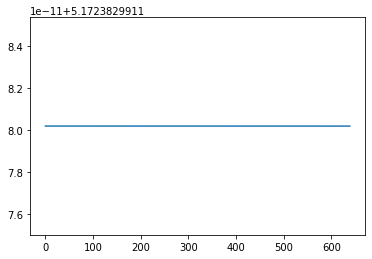

In [17]:
x_0 = spm_sol2["Negative electrode SOC"].data
y_0 = spm_sol2["Positive electrode SOC"].data
plt.plot(x_0 * Cn + y_0 * Cp)